<a href="https://colab.research.google.com/github/Dworlock11/Exoplanet-Machine-Learning-Analysis/blob/main/Exoplanet_Habitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, make_scorer, classification_report, f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
from warnings import simplefilter
from scipy.stats import randint, uniform

df = pd.read_excel("Exoplanet Catalog.xlsx")
pd.set_option('display.max_columns', None)
df

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,P_ATMOSPHERE,S_NAME,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_METALLICITY,S_METALLICITY_ERROR_MIN,S_METALLICITY_ERROR_MAX,S_MASS,S_MASS_ERROR_MIN,S_MASS_ERROR_MAX,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TYPE,S_AGE,S_AGE_ERROR_MIN,S_AGE_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_DISC,S_MAGNETIC_FIELD,S_LOG_G,S_ALT_NAMES,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,P_TYPE,S_RADIUS_EST,S_TYPE_TEMP,S_RA_H,S_RA_T,S_DEC_T,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007.0,2014-05-14,326.030000,-0.320,0.320,1.29000,-0.050,0.050,0.231,-0.005,0.005,NaN,NaN,NaN,94.8,-1.5,1.5,2452899.6,-1.6,1.6,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 Com,185.179280,17.792868,4.740,93.37,-1.92,1.92,-0.35,-0.09,0.09,2.70,-0.300,0.300,19.000000,-2.000,2.000,K0 III,NaN,NaN,NaN,4742.0,-100.0,100.0,NaN,NaN,2.31,"HD 107383, HIP 60202",NaN,NaN,NaN,NaN,0.130671,1.324418,0.99201,1.58799,1.298759,101.011410,64.855456,166.191940,799.44963,722.98875,914.73942,Jovian,19.000000,K,12.345286,12 20 43.0286,+17 47 34.3248,163.546800,10.132812,24.763411,12.834754,23.477907,13.586847,23.477907,12.390643,23.477907,34.529063,0.476460,0.642400,0.0,0.0,Hot,0.0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009.0,2018-09-06,516.219970,-3.200,3.200,1.53000,-0.070,0.070,0.080,-0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 UMi,229.274540,71.823898,5.016,125.72,-1.97,1.97,-0.02,NaN,NaN,2.78,-0.690,0.690,29.790000,-2.840,2.840,K4 III,NaN,NaN,NaN,4213.0,-46.0,46.0,NaN,NaN,1.93,"HD 136726, HIP 74793",NaN,NaN,NaN,NaN,0.167551,1.534896,1.40760,1.65240,1.531227,107.351180,91.741348,126.426170,819.07569,788.47184,854.28770,Jovian,29.790000,K,15.284970,15 17 05.8915,+71 49 26.0328,250.492940,12.770059,31.984271,16.175280,30.323783,17.134143,30.323783,15.615215,30.323783,42.732816,0.193891,0.648683,0.0,0.0,Hot,0.0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008.0,2014-05-14,185.840000,-0.230,0.230,0.83000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2452861.4,-1.5,1.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,14 And,352.822570,39.236198,5.227,75.59,-0.71,0.71,-0.24,-0.03,0.03,2.20,-0.200,0.100,11.000000,-1.000,1.000,G8 III,NaN,NaN,NaN,4813.0,-20.0,20.0,NaN,NaN,2.63,"HD 221345, HIP 116076",NaN,NaN,NaN,NaN,0.073485,0.830000,0.83000,0.83000,0.830000,84.446427,84.446427,84.446427,772.30746,772.30746,772.30746,Jovian,11.000000,G,23.521506,23 31 17.4215,+39 14 10.3128,58.175144,6.025230,14.680087,7.631867,13.918028,8.078404,13.918028,7.367780,13.918028,20.593611,0.502752,0.600010,0.0,0.0,Hot,0.0,0.081917,Andromeda,And,And

# Preprocessing

As many of the columns from the dataset contain a lot of null entries, it is best to simply remove them. All columns with the number of null values greater than a quarter the length of the dataset are removed.

In [2]:
col_non_null_count = df.isna().sum()
cols_non_majority_null = col_non_null_count[col_non_null_count < len(df)/4].index.to_list()
df = df[cols_non_majority_null]

Additional feature selection is conducted, as many of the features are unhelpful for model training, are copies of one another, or are close in value.

In [3]:
df = df.drop(["P_NAME", "P_STATUS", "P_RADIUS", "P_YEAR", "P_UPDATED", "S_NAME", "S_RADIUS", "S_ALT_NAMES", "P_HABZONE_OPT", "P_HABZONE_CON", "S_CONSTELLATION_ABR", "P_PERIOD_ERROR_MIN", "P_PERIOD_ERROR_MAX", "S_DISTANCE_ERROR_MIN", "S_DISTANCE_ERROR_MAX", "P_FLUX_MIN", "P_FLUX_MAX", "P_TEMP_EQUIL_MIN", "P_TEMP_EQUIL_MAX"], axis=1)
df.shape

(4049, 48)

Categorical features with far too many unique values are removed to simplify the model after encoding.

In [4]:
num_features = df.select_dtypes(include=np.number)
cat_features = df.select_dtypes(exclude=np.number)

for col in cat_features.columns:
  print(col, "-", len(cat_features[col].value_counts()))

df = df.drop(["S_RA_T", "S_DEC_T", "S_CONSTELLATION", "S_CONSTELLATION_ENG"], axis=1)

P_DETECTION - 10
P_TYPE - 6
S_TYPE_TEMP - 7
S_RA_T - 3010
S_DEC_T - 3010
P_TYPE_TEMP - 3
S_CONSTELLATION - 88
S_CONSTELLATION_ENG - 88


The data is checked for the skew of each feature to determine the appropriate imputing method. Since the data is heavily skewed, the median will be chosen.

In [5]:
df.skew(axis=0, numeric_only=True, skipna=True).sort_values(ascending=False)

,0
P_PERIOD,62.170001
P_FLUX,45.699102
S_MASS_ERROR_MAX,45.649624
S_ABIO_ZONE,39.242821
S_RADIUS_ERROR_MAX,31.053663
P_PERIASTRON,28.463444
P_SEMI_MAJOR_AXIS_EST,28.395487
P_DISTANCE_EFF,28.376942
P_DISTANCE,28.337572
P_APASTRON,28.236115


The distribution of the target is observed.

In [6]:
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,58
Miniterran,1


A single Miniterran planet can't be split amongst a training and test set. According to the official classification practice of exoplanets, Miniterrans have a radius between 0.03 and 0.04 times that of Earth. Subterrans have a radius between 0.4 and 0.8 times that of Earth. If the Miniterran in the data has a radius close to that of Subterrans, it wouldn't be a problem to mask it as one.

In [7]:
miniterran = df[df["P_TYPE"] == "Miniterran"]
miniterran["P_RADIUS_EST"]

,P_RADIUS_EST
3770,0.333946


Indeed, the radius is around 0.33 times that of Earth, which isn't too far from the 0.4 minimum for a Subterran. Therefore, the planet is masked as one.

In [8]:
df["P_TYPE"] = df["P_TYPE"].mask(df["P_TYPE"] == "Miniterran", "Subterran")
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,59


# Logistic Regression

The data is separated into the features and the target.

In [9]:
X = df.drop(["P_TYPE"], axis=1)
y = df["P_TYPE"]

All rows where the target value is null are removed.

In [10]:
y_na = y[y.isna()]
data = X.join(y)
data = data.drop(y_na.index)
X = data.drop("P_TYPE", axis=1)
y = data["P_TYPE"]
print(y.isna().sum())

0


The data is split into the training and testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

Transformers for numerical and categorical data are created.

In [12]:
# Separate numerical and categorical features
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Build transformers
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", feature_name_combiner="concat"))
])

# Combine transformers
log_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [13]:
log_pipe = Pipeline([
    ("log_preprocessor", log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}

search = RandomizedSearchCV(log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [14]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

log_reg__C : 372.7593720314938


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.97      0.98       260
   Neptunian       0.94      0.94      0.94       180
   Subterran       0.58      0.58      0.58        12
 Superterran       0.96      0.97      0.96       220
      Terran       0.94      0.94      0.94       135

    accuracy                           0.95       807
   macro avg       0.88      0.88      0.88       807
weighted avg       0.95      0.95      0.95       807



The model performs very well across all metrics.

Permutation is used to find the importance of the individual features. It will be used across all models for standardized results. The test set must be manually transformed with all preprocessing steps before implementing permutation to match the number of columns present in the model.

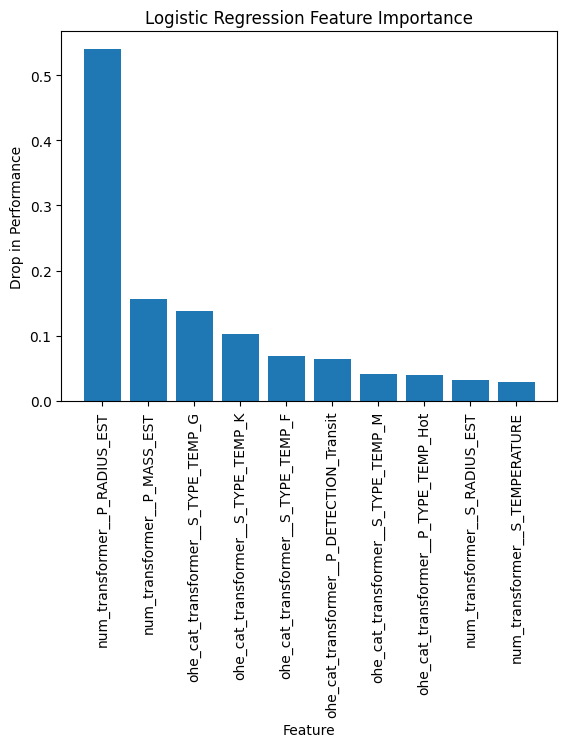

In [16]:
# Extract components
preprocessor = best_model.named_steps["log_preprocessor"]
log_reg = best_model.named_steps["log_reg"]
feature_names = preprocessor.get_feature_names_out()

raw_feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(log_reg, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

Apparently, the top two most important features for predicting the type of the planet is P_RADIUS_EST. This make sense, as the classification of a planet is based on the planet's radius compared to Earth's.

# Polynomial Logistic Regression

Now polynomial features will be added to see if there will be a significant difference.

Transformers are created once again.

In [17]:
# Build transformers
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# Combine transformers
poly_log_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [18]:
poly_log_pipe = Pipeline([
    ("poly_log_preprocessor", poly_log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}


search = RandomizedSearchCV(poly_log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [19]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

log_reg__C : 51.794746792312125


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.99      0.96      0.97       260
   Neptunian       0.93      0.94      0.94       180
   Subterran       0.62      0.67      0.64        12
 Superterran       0.94      0.97      0.95       220
      Terran       0.94      0.92      0.93       135

    accuracy                           0.95       807
   macro avg       0.88      0.89      0.89       807
weighted avg       0.95      0.95      0.95       807



The model performs reasonably well across all metrics.

Feature importance is ignored, as most of the features are simply engineered polynomial features.

# Decision Tree

Now, a decision tree model will be trained following the same process.

A new categorical transformer is created using ordinal encoding, which is suitable for tree-based models.

In [21]:
tree_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine transformers
tree_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("tree_cat_transformer", tree_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented, testing ranges of values for the major hyperparameters.

In [22]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeClassifier())
])

param_dist = {
    "dec_tree__max_depth": [None, 2, 5, 10, 20],
    "dec_tree__min_samples_split": [2, 5, 10, 20, 50],
    "dec_tree__min_samples_leaf": [1, 2, 5, 10, 20],
    "dec_tree__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [23]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

dec_tree__min_samples_split : 2
dec_tree__min_samples_leaf : 5
dec_tree__max_features : None
dec_tree__max_depth : 10


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.99      0.99       260
   Neptunian       0.98      0.97      0.98       180
   Subterran       1.00      1.00      1.00        12
 Superterran       1.00      1.00      1.00       220
      Terran       1.00      1.00      1.00       135

    accuracy                           0.99       807
   macro avg       0.99      0.99      0.99       807
weighted avg       0.99      0.99      0.99       807



The metrics are notably better than those from the logistic regression model. Perhaps decision trees are better suited to multiclass classification.

Permutation is once again used to discover feature importance.

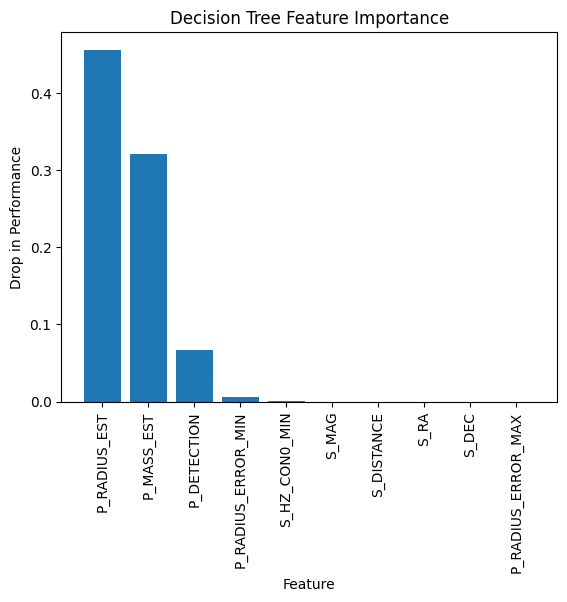

In [25]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
dec_tree = best_model.named_steps["dec_tree"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(dec_tree, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

As before, P_RADIUS_EST and P_MASS_EST are the two most important features. However, the other features have even less importance compared to those two than they did in the logistic regression model.

# Random Forest

Now, a random forest model will be trained. The pipeline is created and hyperparameter tuning is implemented, testing ranges of values for the major hyperparameters.

In [26]:
forest_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("rand_for", RandomForestClassifier())
])

param_dist = {
    # "rand_for__n_estimators": [200, 400, 600, 800],
    # "rand_for__max_depth": [None, 5, 10, 20, 40],
    # "rand_for__min_samples_split": [2, 5, 10, 20],
    # "rand_for__min_samples_leaf": [1, 2, 5, 10],
    # "rand_for__max_features": ["sqrt", "log2", None],
    # "rand_for__bootstrap": [True, False],

    "rand_for__n_estimators" : [600],
    "rand_for__min_samples_split" : [5],
    "rand_for__min_samples_leaf" : [2],
    "rand_for__max_features" : [None],
    "rand_for__max_depth" : [40],
    "rand_for__bootstrap" : [True]
}

search = RandomizedSearchCV(forest_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [27]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

rand_for__n_estimators : 600
rand_for__min_samples_split : 5
rand_for__min_samples_leaf : 2
rand_for__max_features : None
rand_for__max_depth : 40
rand_for__bootstrap : True


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.99      0.99       260
   Neptunian       0.98      0.97      0.98       180
   Subterran       1.00      1.00      1.00        12
 Superterran       1.00      1.00      1.00       220
      Terran       1.00      1.00      1.00       135

    accuracy                           0.99       807
   macro avg       0.99      0.99      0.99       807
weighted avg       0.99      0.99      0.99       807



The metrics are even better than those from the decision tree model, almost perfect. Including many trees must have increased the overall score.

Permutation is once again used to discover feature importance.

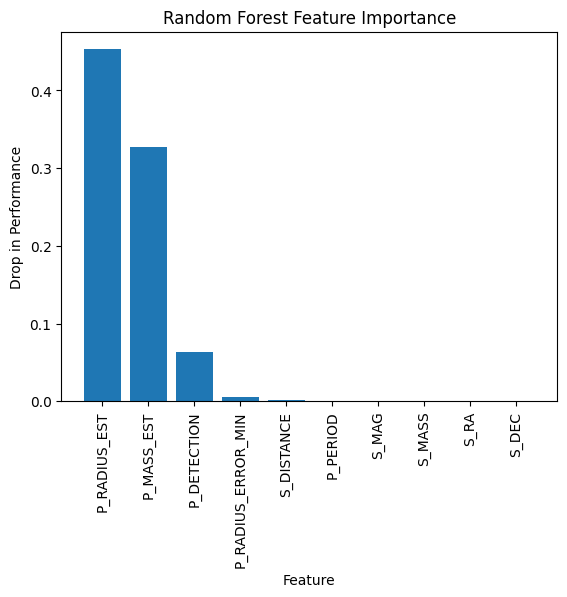

In [29]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
rand_for = best_model.named_steps["rand_for"]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(rand_for, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

As before, P_RADIUS_EST and P_MASS_EST are the two most important features. As with the decision tree model, the other features have little importance compared to those two.

# Ridge Regression

Now, the mass of planets will be predicted using various models,starting with Ridge regression. Ridge is chosen over standard linear regression to enable regularization.

The data is separated into the features and the target.

In [30]:
X = df.drop(["P_MASS_EST"], axis=1)
y = df["P_MASS_EST"]

All rows where the target value is null are removed.

In [31]:
y_na = y[y.isna()]
data = X.join(y)
data = data.drop(y_na.index)
X = data.drop("P_MASS_EST", axis=1)
y = data["P_MASS_EST"]
print(y.isna().sum())

0


The data is split into the training and testing data.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

Transformers for numerical and categorical data are created.

In [33]:
# Separate numerical and categorical features
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Combine transformers
ridge_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [34]:
ridge_pipe = Pipeline([
    ("ridge_preprocessor", ridge_preprocessor),
    ("ridge", Ridge())
])

kf = KFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "ridge__alpha": np.logspace(-4, 4, 50)
}

search = RandomizedSearchCV(ridge_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [35]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

ridge__alpha : 1.2067926406393288


In [36]:
print(classification_report(y_test, y_pred))

ValueError: continuous is not supported

The model performs reasonably well across all metrics.

Permutation is used to find the importance of the individual features. The test set must be manually transformed with all preprocessing steps before implementing permutation to match the number of columns present in the model.

In [ ]:
# Extract components
preprocessor = best_model.named_steps["ridge_preprocessor"]
ridge = best_model.named_steps["ridge"]
feature_names = preprocessor.get_feature_names_out()

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(ridge, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Ridge Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

Apparently, the top two most important features for predicting the type of the planet are P_MASS_EST and P_RADIUS_EST. This make sense, as the classification of a planet is based on the planet's radius and mass compared to Earth's.

# Polynomial Ridge Regression

The output from Ridge will be compared to its output with polynomial features.

The pipeline is created and hyperparameter tuning is implemented.

In [ ]:
poly_ridge_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

In [ ]:
poly_ridge_pipe = Pipeline([
    ("poly_ridge_preprocessor", poly_ridge_preprocessor),
    ("ridge", Ridge())
])

kf = KFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "ridge__alpha": np.logspace(-4, 4, 50)
}

search = RandomizedSearchCV(poly_ridge_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [ ]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

The model performs reasonably well across all metrics.